In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Load the cleaned Multiple Sclerosis dataset from an Excel file
df = pd.read_excel("ms_text_data_cleaned.xlsx")

# Count the number of occurrences for each class label to assess class distribution
counts = df['label'].value_counts()

# Print the distribution of labels to understand the dataset imbalance
print(counts)
# The output reveals the number of samples per label class, highlighting potential imbalance


label
NEDA    4989
EDA     1483
Name: count, dtype: int64


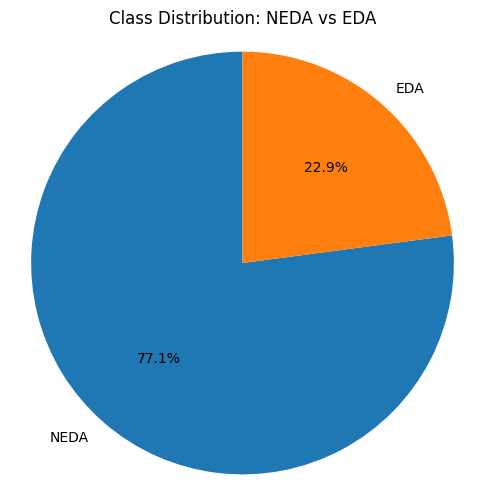

In [ ]:
import matplotlib.pyplot as plt

# Define class labels and their corresponding sample counts
labels = ['NEDA', 'EDA']
sizes = [4989, 1483]  # NEDA has more samples than EDA, showing class imbalance

# Create a pie chart to visually display the class distribution
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution: NEDA vs EDA')  # Title emphasizes the imbalance issue
plt.axis('equal')  # Ensures the pie chart is circular
plt.show()  # Render the plot


In [ ]:
# Drop the first column which contains database IDs, as it is not needed for analysis or modeling
df = df.drop(df.columns[0], axis=1)


In [ ]:
# Separate the dataset into majority and minority classes
df_majority = df[df["label"] == "NEDA"]  # Majority class (more samples)
df_minority = df[df["label"] == "EDA"]   # Minority class (fewer samples)


In [ ]:
# Perform undersampling of the majority class (NEDA) to match the minority class (EDA) count
# This helps balance the dataset for model training
df_majority_down = resample(
    df_majority,
    replace=False,           # Sample without replacement
    n_samples=len(df_minority),  # Match the number of minority samples
    random_state=42          # Ensure reproducibility
)


In [ ]:
# Shuffle both the downsampled majority class and minority class to randomize order
# This prevents any ordering bias when combining or splitting the dataset
df_majority_down = df_majority_down.sample(frac=1, random_state=42).reset_index(drop=True)
df_minority = df_minority.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
# Interleave rows from minority and downsampled majority classes
# This creates a balanced dataset while maintaining alternating examples from each class
before_balanced_rows = []
for m_row, M_row in zip(df_minority.iterrows(), df_majority_down.iterrows()):
    before_balanced_rows.append(m_row[1])
    before_balanced_rows.append(M_row[1])


In [ ]:
# Convert the interleaved rows into a new DataFrame
# Reset the index to have a clean, continuous integer index
before_balanced_df = pd.DataFrame(before_balanced_rows)
before_balanced_df = before_balanced_df.reset_index(drop=True)


In [ ]:
before_balanced_df.head()

,text,output,label
0,Age:50. Gender:female. Diagnosis:rrms. Conve...,After 2 months the patient will be in EDA.,EDA
1,Age:40. Gender:female. Diagnosis:rrms. Has n...,After 4 months the patient will be in NEDA.,NEDA
2,Age:80. Gender:female. Diagnosis:spms. Conve...,After 9 months the patient will be in EDA.,EDA
3,Age:34. Gender:female. Diagnosis:rrms. Has n...,After 7 months the patient will be in NEDA.,NEDA
4,Age:58. Gender:female. Diagnosis:nmo. Has no...,After 1 months the patient will be in EDA.,EDA


In [ ]:
before_balanced_df.describe()

,text,output,label
count,2966,2966,2966
unique,2966,116,2
top,Age:50. Gender:male. Diagnosis:rrms. Has not...,After 6 months the patient will be in NEDA.,EDA
freq,1,258,1483


In [ ]:
# Count the number of samples per class after undersampling/interleaving
# Print the counts to verify that the dataset is now balanced
counts = before_balanced_df['label'].value_counts()
print(counts)


label
EDA     1483
NEDA    1483
Name: count, dtype: int64


# Creating an additional validation set to support robust model evaluation



In [ ]:
# Split the balanced dataset into training and testing sets
# 80% of the data is used for training, 20% for testing
# Shuffle is enabled to ensure random distribution of classes
train_df, test_df = train_test_split(before_balanced_df, test_size=0.2, random_state=42, shuffle=True)


In [ ]:
# Save the training and testing datasets to JSON files
# Format: list of records with indentation for readability
# These files will be used for model fine-tuning and evaluation
train_df.to_json("train_balanced.json", orient="records", indent=4)
test_df.to_json("test_balanced.json", orient="records", indent=4)


In [ ]:
# Split the balanced dataset into train, validation, and test sets
# 70% train, 15% validation, 15% test
# Two-step splitting ensures proper ratios while shuffling data for randomness
from sklearn.model_selection import train_test_split

# First split: separate out the test set (15% of total data)
train_val_df, test_df = train_test_split(
    before_balanced_df,
    test_size=0.15,
    random_state=42,
    shuffle=True
)

# Second split: carve out validation set from remaining 85% (approx 15% of total)
val_size = 0.15 / 0.85  # adjusted proportion
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_size,
    random_state=42,
    shuffle=True
)


In [ ]:
# Exporting the final train, validation, and test splits as JSON files for downstream modeling
train_df.to_json("train.json", orient="records", indent=4)
val_df.to_json("val.json", orient="records", indent=4)
test_df.to_json("test.json", orient="records", indent=4)


In [ ]:
# Load and inspect the first 5 records from the balanced training dataset to verify structure
import json

with open("train_balanced.json", "r") as f:
    data = json.load(f)

print(json.dumps(data[:5], indent=4))


[
    {
        "text": "Age:41.  Gender:female.  Diagnosis:rrms. Has not converted to SPMS. Initial presentation motor weakness, cerebellar. Number of attacks until the first visit:4. Name of co-morbidity:Depression. More information on co-morbidity:Depression. Outcome:ongoing illness. Visit diagnosis:rrms. DMT taken. Current DMT:mabthera- rituximab on November 01, 2011. EDSS:0- normal neurological exam (all FS grade 0). The patient is in EDA. Will the patient be in NEDA or EDA after 18 months?",
        "output": "After 18 months the patient will be in EDA.",
        "label": "EDA"
    },
    {
        "text": "Age:60.  Gender:female.  Diagnosis:spms. Converted to SPMS.  Initial presentation motor weakness. Number of attacks until the first visit:3. Name of co-morbidity:Depression. More information on co-morbidity:Depression. Outcome:ongoing illness. Name of co-morbidity:Bell's Palsy. Outcome:completely recovered from illness. Name of co-morbidity:Osteoporosis or osteopenia. More inf